In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# connect, give access, and "download" your drive on the google VM
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# change to your path to the dataset in drive (create a shortcut of shared ML_project in "MyDrive")
#your_drive_path = '/content/drive/MyDrive/ML_project/dataset.parquet'
local_path = 'dataset.parquet'

In [3]:
df = pd.read_parquet(local_path, engine='pyarrow')

# Initial preprocessing

We create a video_id which identifies each video.


In [4]:
# Find the rows where time is 0
start_of_video = df['time(s)'] == 0

# Use cumsum to create a unique video_id for each video
df['video_id'] = start_of_video.cumsum() - 1

# Forward-fill the video_id to all rows within the same video series
df['video_id'] = df['video_id'].ffill(downcast='int')

# Reorder columns, moving 'video_id' to the first position
df = df[['video_id'] + [col for col in df.columns if col != 'video_id']]

C:\Users\41794\AppData\Local\Temp\ipykernel_18768\2335139889.py:8: FutureWarning: The 'downcast' keyword in ffill is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df['video_id'] = df['video_id'].ffill(downcast='int')


We then onehot encode exercises.

In [5]:
one_hot_encoded_exercises = pd.get_dummies(df['Exercise'], prefix='encoded_exo')

# Concatenate the new one-hot encoded columns to the original DataFrame
df = pd.concat([df, one_hot_encoded_exercises], axis=1)

We first drop the first 2 seconds and the last second of each video, because they approximately correspond to a reference pose and clapping.

In [6]:
# Drop the first 60 frames and the last 30 frames for each video
df = df.groupby('video_id').apply(lambda group: group.iloc[60:-30]).reset_index(drop=True)

We will now handle missing values. We will crop parts of videos that have more than 20 (obtained by cross validation) missing continuous frames. Then we will perform linear interpolation to estimate missing joint positions that consist of less than 20 continuous frames.

In [7]:
nan_mask = df.isna().any(axis = 1)
# Get the indices of the rows with NaN values
nan_indices = [i for i, has_nan in enumerate(nan_mask) if has_nan]

th = 20
current_sequence_length = 1
ids = []
tmp = []

# Get indices that have more than 20 continuous missing frames
for i in range(1, len(nan_indices)-1):
    tmp.append(nan_indices[i])
    if nan_indices[i] == nan_indices[i + 1] - 1:
        current_sequence_length += 1
    else:
        if current_sequence_length > th:
            ids.append(tmp)
        tmp = []
        current_sequence_length = 1
ids = np.concatenate(ids)

# Drop rows based on iloc indices
df = df.drop(ids)

# Reset index if needed
df = df.reset_index(drop=True)

In [8]:
#Interpolating linearly for the missing frames
df = df.interpolate(method='linear', axis=0, limit_direction='both')

C:\Users\41794\AppData\Local\Temp\ipykernel_18768\3724438224.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear', axis=0, limit_direction='both')


# Train / test split

We now split the dataset into two dataframes, containing the train and test sets. We select 5 participants that will be in the test set, while others will be in the train set.

In [9]:
# Combine 'Set' and 'Exercise' columns to create a new column for grouping
df['Combined_Labels'] = df['Set'].astype(str) + '_' + df['Exercise'].astype(str)

# Select participants that will be part of the test set
test_participants = ['P04','P05','P09','P11','P12']

# Split into train and test sets
train_set = df[~df['Participant'].isin(test_participants)]
test_set = df[df['Participant'].isin(test_participants)]

# Check that both sets contain a maximum amount of labels
unique_labels_train = train_set['Combined_Labels'].nunique()
unique_labels_test = test_set['Combined_Labels'].nunique()

print("Train set contains ",unique_labels_train,"/38 labels.")
print("Test set contains ",unique_labels_test,"/38 labels.")

# Drop the temporary 'Combined_Labels' column
train_set = train_set.drop('Combined_Labels', axis=1)
test_set = test_set.drop('Combined_Labels', axis=1)

Train set contains  38 /38 labels.
Test set contains  37 /38 labels.


# Data Augmentation

Let's look at the distribution of our train set

C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

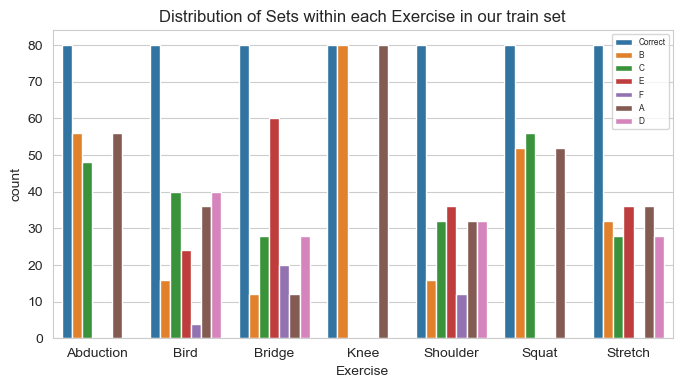

In [10]:
# Aggregate the data at the video level
video_aggregated = train_set.groupby(['video_id', 'Exercise', 'Set']).size().reset_index(name='Count')

# Plot the distribution of Sets within each Exercise
plt.figure(figsize=(8, 4))
sns.countplot(x='Exercise', hue='Set', data=video_aggregated)

# Reduce the size of the legend
plt.legend(prop={'size': 6})

plt.title('Distribution of Sets within each Exercise in our train set')
plt.show()

We can see that our train set is heavily unbalanced. We will thus, balance our dataset by randomly sampling a video of a certain type (Exercise,Set), duplicate it, add gaussian noise to it, and append it to our train set. This will also make the model more robust to noise.

In [12]:
def add_gaussian_noise_to_series(series_df, video_id, noise_std):
    # Extract the video series based on the provided video_id
    video_series = series_df[series_df['video_id'] == video_id].copy()

    # Add Gaussian noise to the joint positions
    for col in video_series.columns[6:105]:
        noise = np.random.normal(0, noise_std, len(video_series))
        video_series[col] += noise

    # Clip the joint positions to be within the -1 to 1 range
    video_series.iloc[:, 6:105] = np.clip(video_series.iloc[:, 6:105], -1, 1)

    # Increment the series_id for the new video
    video_series['video_id'] = series_df['video_id'].max() + 1

    # Append the new video to the DataFrame
    return pd.concat([series_df, video_series], ignore_index=True)

In [13]:
def augment_videos(combination, df, desired_count):
    # Extract exercise and set values from the combination
    exercise, set_value = combination

    # Count the current number of unique videos for the given combination of exercise and set
    current_count = len(df[(df['Exercise'] == exercise) & (df['Set'] == set_value)]['video_id'].unique())

    # Calculate the number of videos to add to reach the desired count
    videos_to_add = desired_count - current_count

    # Loop to add videos with Gaussian noise
    for _ in range(videos_to_add):
        # Set the standard deviation for Gaussian noise
        noise_std = 0.1

        # Sample a random video_id from the given combination of exercise and set
        sampled_video_id = df[(df['Exercise'] == exercise) & (df['Set'] == set_value)]['video_id'].sample().values[0]

        # Apply the function to add Gaussian noise to the sampled video
        df = add_gaussian_noise_to_series(df, sampled_video_id, noise_std)

    return df

In [14]:
# Define the desired number of videos per combination
desired_videos_per_combination = 85

# Group by "Exercise" and "Set" and count the number of unique videos in each group
video_counts = train_set.groupby(['Exercise', 'Set'])['video_id'].nunique()

# Identify combinations that need augmentation
combinations_to_augment = video_counts[video_counts < desired_videos_per_combination].index


# Augment videos for combinations that need it
for combination in combinations_to_augment:
    train_set = augment_videos(combination, train_set, desired_videos_per_combination)

C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

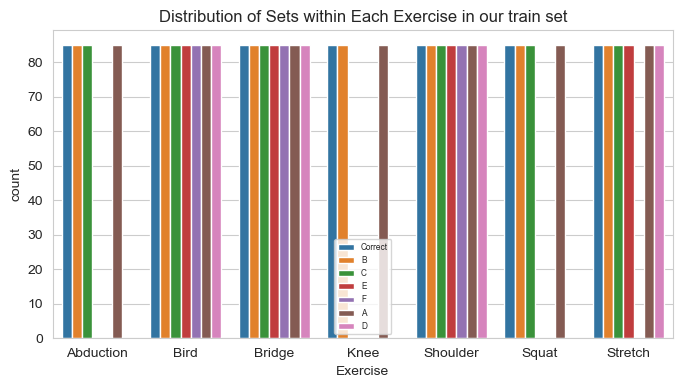

In [15]:
# Verify the result

# Aggregate the data at the video level
video_aggregated = train_set.groupby(['video_id', 'Exercise', 'Set']).size().reset_index(name='Count')

# Plot the distribution of Sets within each Exercise
plt.figure(figsize=(8, 4))
sns.countplot(x='Exercise', hue='Set', data=video_aggregated)

# Reduce the size of the legend
plt.legend(prop={'size': 6})

plt.title('Distribution of Sets within Each Exercise in our train set')
plt.show()

The train set it now balanced.

In [16]:
test_path = 'test_set.parquet'
test_set.to_parquet(test_path, index=True)

In [11]:
train_path = 'train_set_augmented.parquet'
train_set.to_parquet(train_path, index=True)